In [202]:
# Regex: Extrato de Contrato

In [203]:
import glob
import re
import pandas as pd
from yattag import Doc
import unicodedata
import os
import json
import numpy as np

In [204]:
doc, tag, text = Doc().tagtext()

In [205]:
txt_files = glob.glob('text/**/**/*.txt')
block_files = glob.glob('blocks/**/**/*.json')

In [206]:
df_dict = {
    'descricao_objeto': [],
    'modalidade_licitatoria': [],
    # 'numero_modalidade': [],
    'processo': [], 
    'texto': []
}

df_dict_block = {
    'descricao_objeto': [],
    'modalidade_licitatoria': [],
    'numero_modalidade': [],
    'processo': [],
    'texto': []
}

regex_dict = {
    'descricao_objeto': r'(EXTRATO (?:DE |DO )?CONTRAT\w+)',
    'modalidade_licitatoria': r'(preg[ãõ\w]+\seletr[ô\w]+|concorrê\w+|tomad\w+\sd\w+\spre[ç\w]+|convite|concurs\w+|leil[ãõ\w]+|ordin[áa]ri\w+|globa\w+|estimativo|PE(?=\sn))',
    # 'modalidade licitatoria': '([\wã]+) eletr[ôoO]nico(\D*)\d{2}\d?/\d{4}',
    # 'numero_modalidade': '\d{5}',
    'processo': r'(?:processo\D+)([\/\d.-]+\d(?:\n\d[\/\d.-]+\d)?)(?:\.,)?',
    # 'processo': r'processo[\s\S]*(\d{5}[\.|\-]\d{8}/\d{4}-\d{2})|\d{3}[\.|/-](\d{3}\.\d{3}|\d{6})/\d{4}'
}

In [207]:
all_contracts = []
prohibited_word = 'aditivo'
for txt in txt_files:
    instances = re.findall(r'((?:EXTRATO (?:DE |DO )?CONTRAT.+[\s ])(?:[\s\S]*?)\.)\n',
                            unicodedata.normalize('NFKD', open(txt, encoding='utf-8').read()), 
                            re.IGNORECASE)
    for instance in instances:
        comparative = str(instance).lower()
        if prohibited_word not in comparative:
            all_contracts.append(instance)
# print(len(all_contracts))
#(EXTRATO ((?:do)|(?:de))? (?:.*CONTRATO)([\s\S]*?))\.\n
# (EXTRATOS? (DE |DO )?CONTRAT)(.*?(\.\n))
# (EXTRATO (?:DE |DO )?CONTRAT.+\s)([\s\S]*?)\.\n
# (EXTRATO (?:DE |DO )?CONTRAT.+[\s ])([\s\S]*?)\.\n


In [209]:
all_contracts_blocks = []
for js in block_files:
    list_blocks = json.loads(open(js, encoding='utf-8').read())
    for block in list_blocks:
        instances = re.findall(r'((?:EXTRATO (?:DE |DO )?CONTRAT.+[\s ])(?:[\s\S]*?)\.)\n',
                               unicodedata.normalize('NFKD', block[4]), 
                               re.IGNORECASE)
        all_contracts_blocks.extend(instances)

In [210]:
for contract in all_contracts:
    df_dict['texto'].append(contract)
    # print(len(contract))
    # print(df_dict['texto'][0])
    # print("---")
    for field in regex_dict:
        match = re.search(regex_dict[field], str(contract), re.IGNORECASE)
       
            
        if match:
            # print(type(match.groups()))
            res = tuple(x for x in match.groups() if x is not None)
            if(len(res)>0):
                df_dict[field].append(res[0])
            else:
                df_dict[field].append(None)
        else:
            df_dict[field].append(np.nan)

df = pd.DataFrame.from_dict(dict([ (k,pd.Series(v)) for k,v in df_dict.items() ]))
df.to_csv('extrato_contrato_regex.csv')
df

,descricao_objeto,modalidade_licitatoria,processo,texto
0,EXTRATO DE CONTRATO,NaN,2628/2018,EXTRATO DE CONTRATO CORRETORA SEGUROS BRB No 0...
1,EXTRATO DE CONTRATO,NaN,NaN,EXTRATO DE CONTRATO CORRETORA SEGUROS BRB No 0...
2,EXTRATO DE CONTRATO,NaN,2600/2018,EXTRATO DE CONTRATO CORRETORA SEGUROS BRB No 0...
3,EXTRATO DO CONTRATO,Pregao Eletronico,00050-00043801/2018-11,EXTRATO DO CONTRATO PARA AQUISICAO DE BENS PEL...
4,EXTRATO DO CONTRATO,Pregao Eletronico,00050-00043801/2018-11,EXTRATO DO CONTRATO PARA AQUISICAO DE BENS PEL...
...,...,...,...,...
2673,EXTRATO DE CONTRATO,NaN,00220-00000166/2020-11,EXTRATO DE CONTRATO\nProcesso: 00220-00000166/...
2674,EXTRATO DO CONTRATO,ORDINARIO,21014/2019,EXTRATO DO CONTRATO No 2/2020 (*)\nContratante...
2675,EXTRATO DO CONTRATO,NaN,NaN,EXTRATO DO CONTRATO BRB 2019/254\nContratante:...
2676,EXTRATO DO CONTRATO,NaN,00392-00010041/2019-10,EXTRATO DO CONTRATO No 03/2020\nProcesso: 0039...


In [211]:
import matplotlib.pyplot as plt
import math

In [212]:
def pizza_plots(df, dim1, dim2):
    _, ax = plt.subplots(dim1, dim2, figsize=(15,15))
    cor = ['#1b9aaa', '#06d6a0']

    i = 0
    print(df.columns)
    df_aux = pd.DataFrame()
    dict_aux = {}
    for id in df.columns:
        total = len(df)
        aparicoes = df[id].count()
        labels = ["Com " + str(id), "Sem " + str(id)]
        size = [aparicoes, total - aparicoes]
        ax[math.floor(i/2), i%2].pie(size, labels=labels, autopct='%1.1f%%', startangle=90, colors=cor)
        ax[math.floor(i/2), i%2].legend(labels, title="Presença", loc='center left', bbox_to_anchor=(1.3, 0, 0.5, 1))
        ax[math.floor(i/2), i%2].axis('off')
        i+=1

    plt.show()

Index(['descricao_objeto', 'modalidade_licitatoria', 'processo', 'texto'], dtype='object')


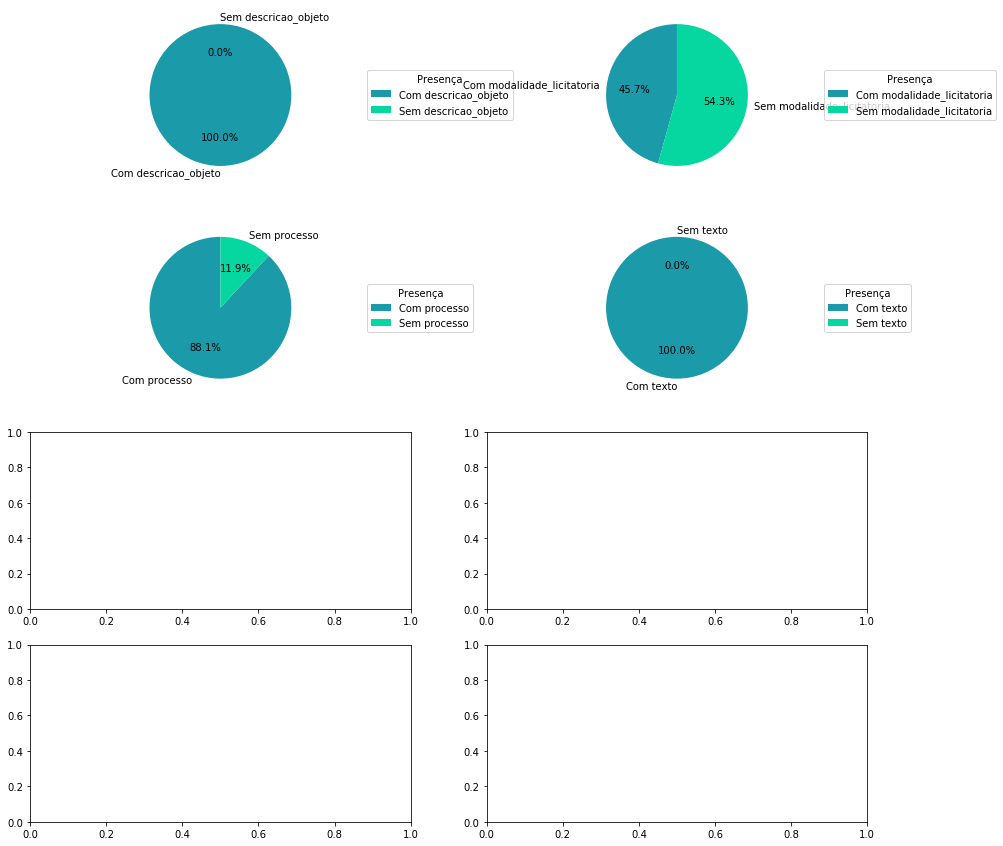

In [213]:
pizza_plots(df, 4, 2)